In [2]:
import pandas as pd
import numpy as np
import os
import sys
from trimesh import load_mesh
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.ccf_utils import ccf_pts_convert_to_mm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cross_decomposition import CCA
%matplotlib inline
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from matplotlib.cm import plasma
from matplotlib.colors import to_hex


In [3]:
# define axis
ml, ap, dv = 0, 2, 1
ml_mesh, ap_mesh, dv_mesh = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
planes_mesh = {'sag': [ap_mesh, dv_mesh], 'hor': [ml_mesh, ap_mesh], 'cor': [ml_mesh, dv_mesh]}

In [4]:
# load merfish data
data_dir = '~/capsule/scratch/combined/merfish/spatial_with_pseudocluster.csv'
merfish_ccf = pd.read_csv(data_dir)
ccf_merfish = merfish_ccf[['AP', 'DV', 'ML']].values
ccf_merfish = ccf_merfish/25
ccf_merfish_mm = ccf_pts_convert_to_mm(ccf_merfish)
merfish_data = merfish_ccf['pseudocluster'].values

# load retro data
data_dir = '/root/capsule/scratch/combined/retro_ccf/manual_proofread_ccf_18brains.csv'
retro_ccf = pd.read_csv(data_dir)
# remove rows with injection_region 'TH'
retro_ccf = retro_ccf[retro_ccf['injection_region'] != 'TH']
ccf_retro = retro_ccf[['x', 'y', 'z']].values
ccf_retro = ccf_retro[:, [2, 1, 0]]
ccf_retro_mm = ccf_pts_convert_to_mm(ccf_retro)
ccf_retro_mm[:, ml_mesh] = -np.abs(ccf_retro_mm[:, ml_mesh])  # Mirror ML to left
region_dummies = pd.get_dummies(retro_ccf['injection_region'])

# Concatenate the dummy columns to your original DataFrame
retro_ccf = pd.concat([retro_ccf, region_dummies[['CTX', 'CB', 'SP']]], axis=1)
# retro_ccf = retro_ccf.drop(columns=['injection_region', 'TH'])

targets = ['CTX', 'CB', 'SP']
retro_dummies = retro_ccf[targets].values

In [5]:
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
ccf_center = np.mean(mesh_vertices_mm, axis=0)

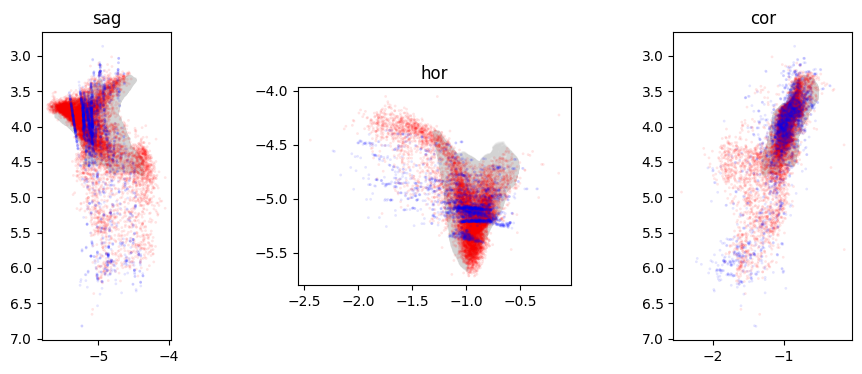

In [6]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 3)
for plane, ax_ind in zip(planes.keys(), range(3)):
    # ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets

    ax = fig.add_subplot(gs[ax_ind])
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
    sc = ax.scatter(ccf_retro_mm[:, planes_mesh[plane][0]], ccf_retro_mm[:, planes_mesh[plane][1]], color='r', alpha=0.1, s=4, edgecolor='none', label='retro')
    sc = ax.scatter(ccf_merfish_mm[:, planes_mesh[plane][0]], ccf_merfish_mm[:, planes_mesh[plane][1]], color='b', alpha=0.1, s=4, edgecolor='none', label='merfish')
    ax.set_aspect(aspect='equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    ax.set_title(plane)

In [7]:
mean_target = np.mean(retro_dummies, axis=0)

In [8]:
retro_centroid_r = 0.1
merfish_centroid_r = 0.1
ranges = {dv:[3, 6.5], ml:[-2.0, -0.3], ap:[-5.9, -4.0]}
grid_size = 0.05
# create grids with ranges with grid_size
ml_grid = np.arange(ranges[ml][0], ranges[ml][1], grid_size)
ap_grid = np.arange(ranges[ap][0], ranges[ap][1], grid_size)
dv_grid = np.arange(ranges[dv][0], ranges[dv][1], grid_size)
ml_grid, ap_grid, dv_grid = np.meshgrid(ml_grid, ap_grid, dv_grid)
ml_grid = ml_grid.flatten()
ap_grid = ap_grid.flatten()
dv_grid = dv_grid.flatten()
grid_points = np.vstack([ap_grid, dv_grid, ml_grid]).T
# initialize merfish and retro mean info for each grid point
merfish_mean = np.zeros((grid_points.shape[0], 1))
retro_mean = np.zeros((grid_points.shape[0], 3))
mean_target = np.mean(retro_dummies, axis=0)

# loop through each grid point to calculate mean retro and mean merfish
for i, point in enumerate(grid_points):
    # calculate distance from retro points
    retro_dist = np.linalg.norm(ccf_retro_mm[:, :] - point, axis=1)
    # calculate distance from merfish points
    merfish_dist = np.linalg.norm(ccf_merfish_mm[:, :] - point, axis=1)
    
    # find those within the radius
    retro_within_radius = np.where(retro_dist < retro_centroid_r)[0]
    merfish_within_radius = np.where(merfish_dist < merfish_centroid_r)[0]

    # calculate mean retro and mean merfish
    if len(retro_within_radius) >= 5:
        retro_mean[i, :] = np.mean(retro_dummies[retro_within_radius, :], axis=0)/mean_target
    else:
        retro_mean[i, :] = np.nan
    
    if len(merfish_within_radius) >= 5:
        merfish_mean[i, :] = np.mean(merfish_data[merfish_within_radius], axis=0)
    else:
        merfish_mean[i, :] = np.nan
presence_mask_merfish = ~np.isnan(merfish_mean[:, 0])
presence_mask_retro = ~np.isnan(retro_mean[:, 0])

/tmp/ipykernel_23726/476057447.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


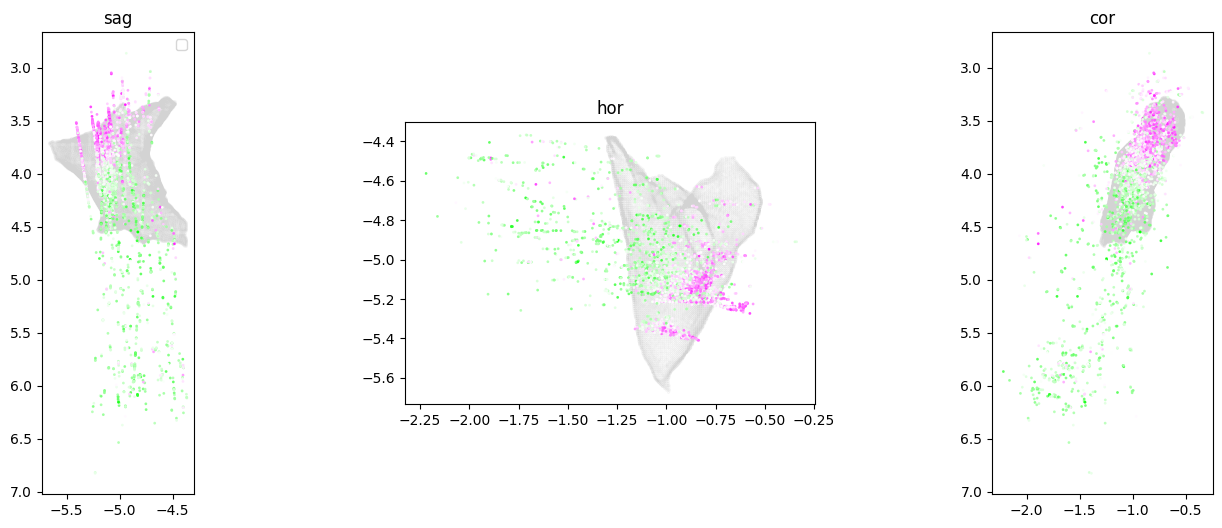

In [9]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex

green_white_magenta = LinearSegmentedColormap.from_list(
    "green_white_magenta",
    ["#00FF00", "#FFFFFF", "#FF00FF"]
)
for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.7, s = 0.002)
    ax.scatter(ccf_merfish_mm[:, planes_mesh[plane][0]], ccf_merfish_mm[:, planes_mesh[plane][1]], c = merfish_ccf['pseudocluster'], cmap=green_white_magenta, alpha=0.9, s = 1)
    ax.set_title(plane)
    if plane == 'sag':
        ax.legend()
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    ax.set_aspect(aspect='equal')


/tmp/ipykernel_23726/2685391841.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


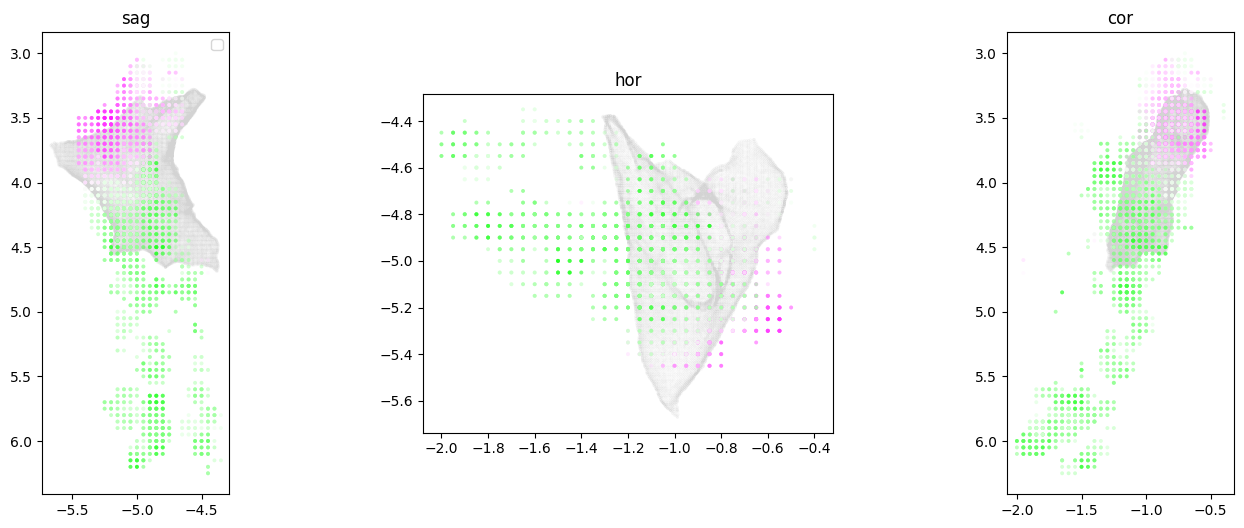

In [10]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex

green_white_magenta = LinearSegmentedColormap.from_list(
    "green_white_magenta",
    ["#00FF00", "#FFFFFF", "#FF00FF"]
)
for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.7, s = 0.002)
    ax.scatter(grid_points[presence_mask_merfish, planes_mesh[plane][0]], grid_points[presence_mask_merfish, planes_mesh[plane][1]], c = merfish_mean[presence_mask_merfish], cmap=green_white_magenta, alpha=0.4, s = 8, edgecolors='none')
    ax.set_title(plane)
    if plane == 'sag':
        ax.legend()
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    ax.set_aspect(aspect='equal')


/tmp/ipykernel_23726/658420484.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


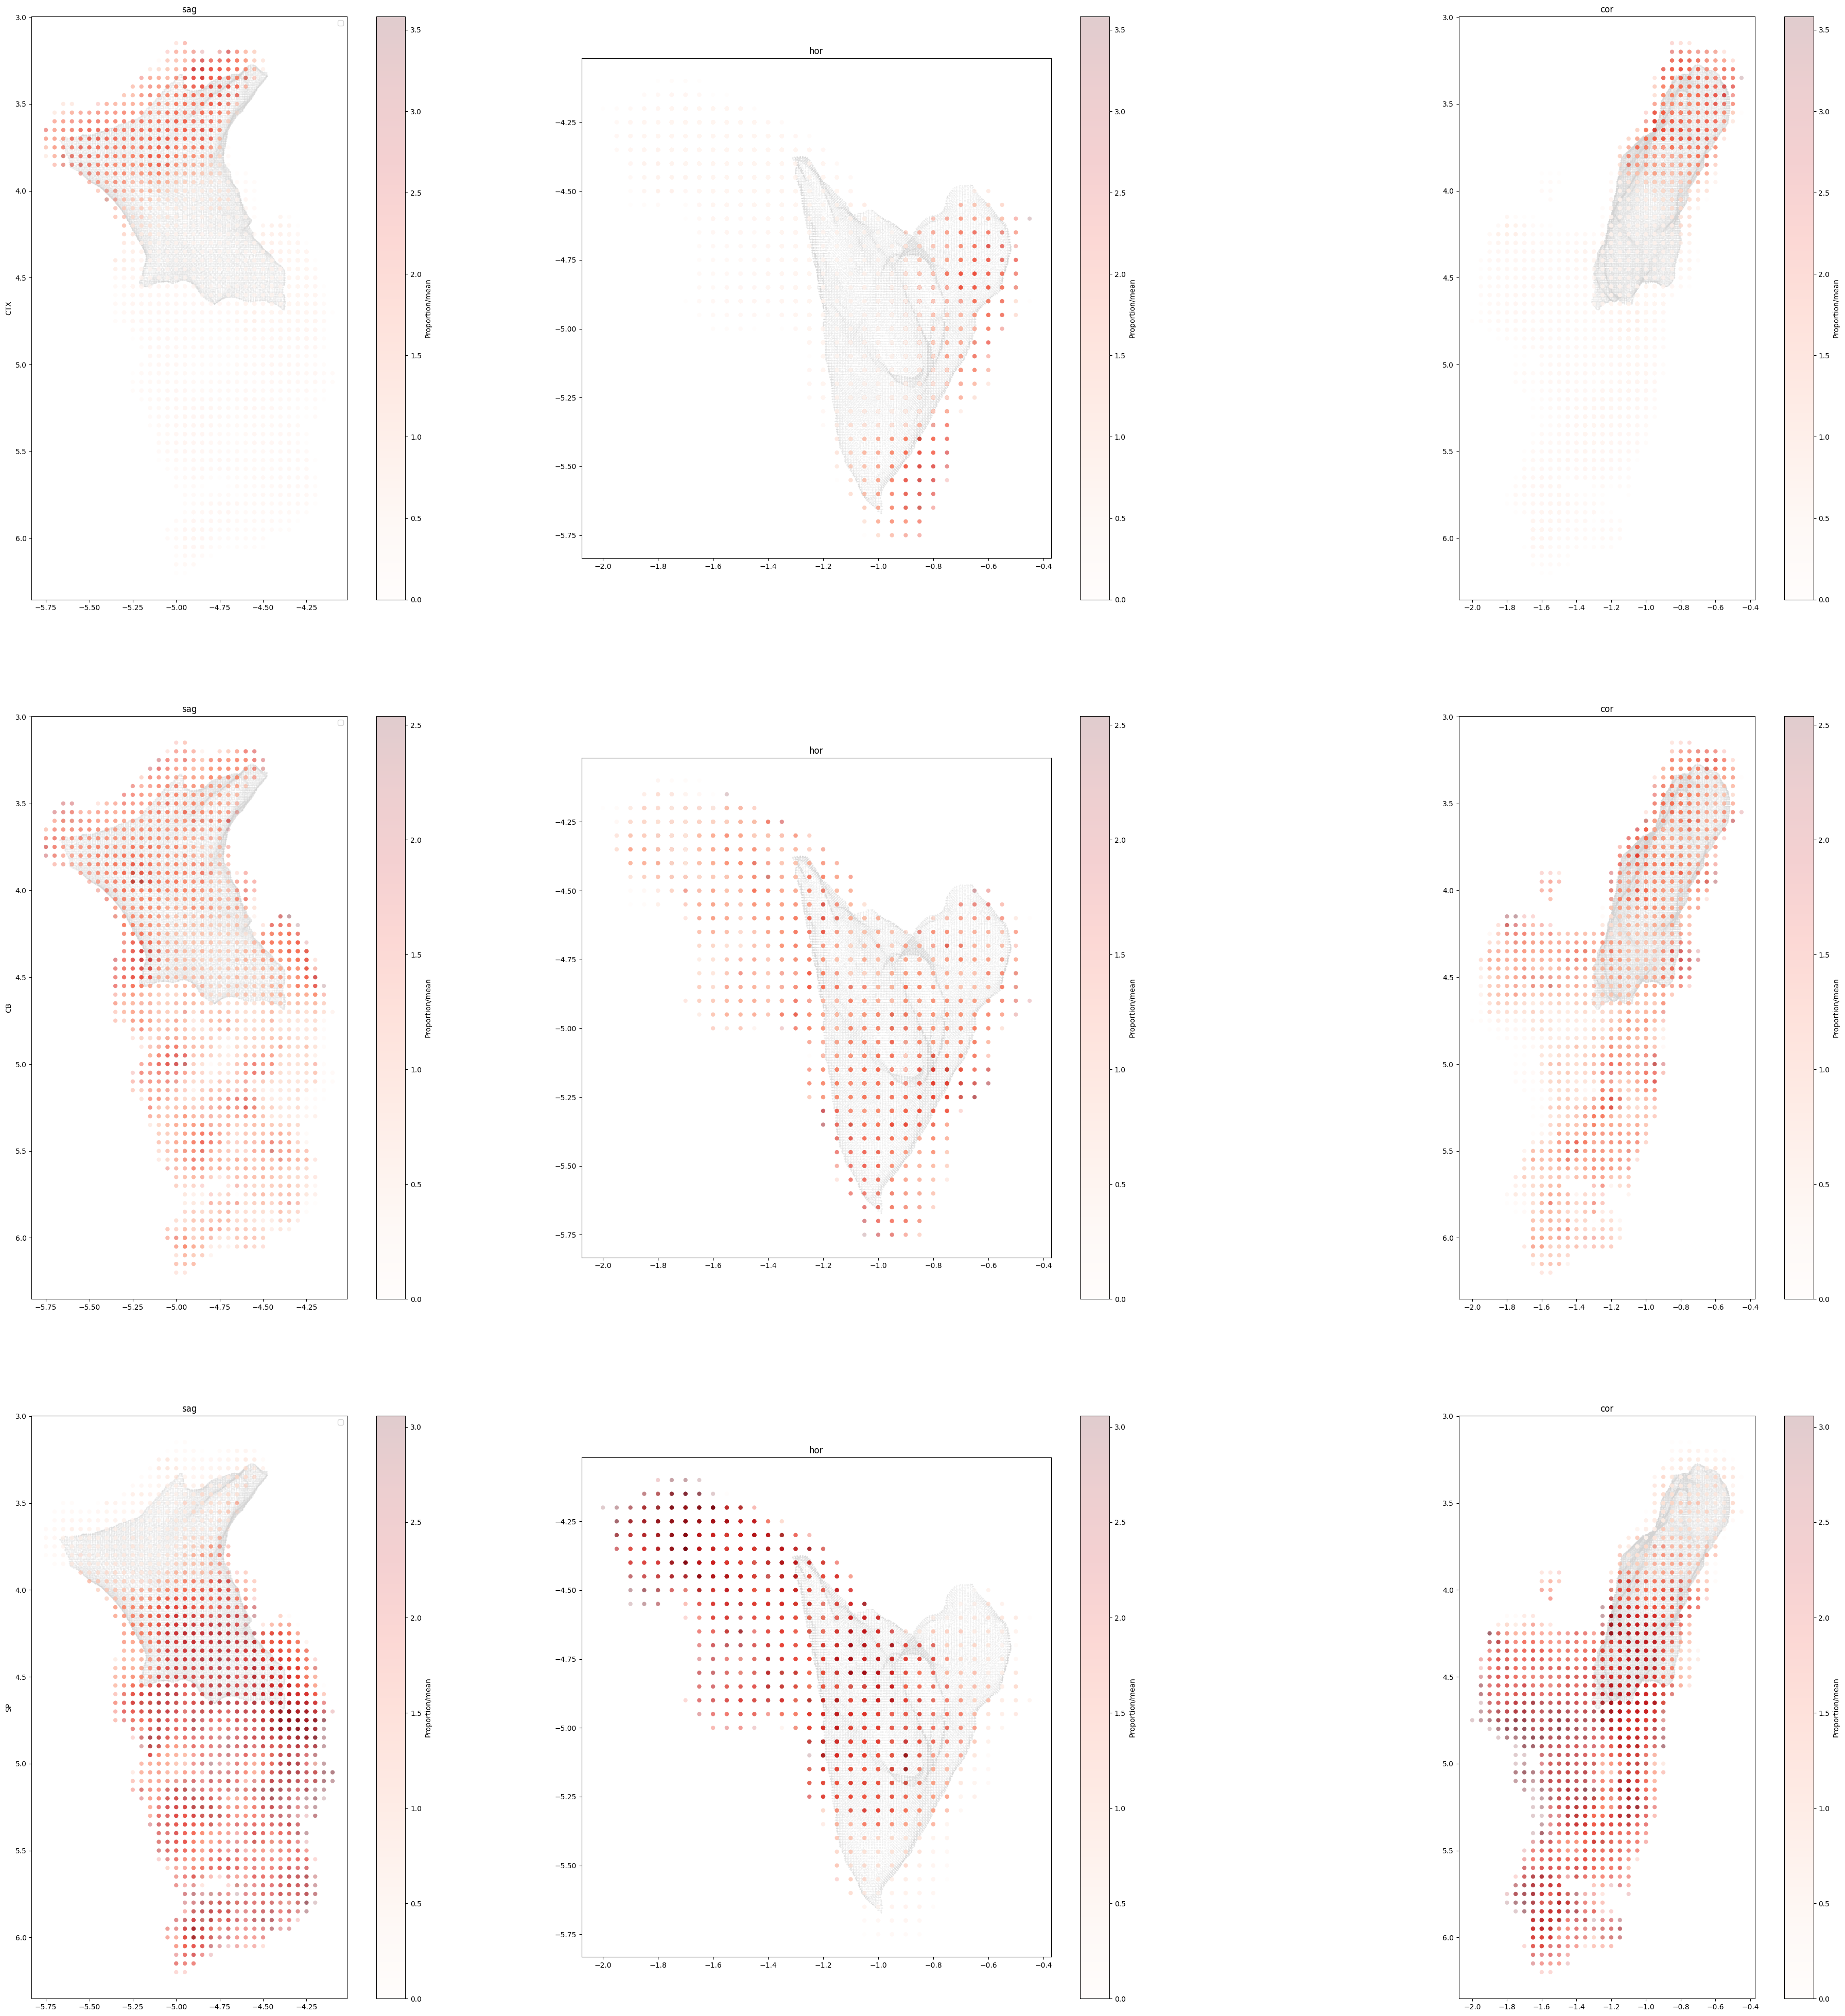

In [11]:
fig = plt.figure(figsize=(50, 50))
gs = fig.add_gridspec(3, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex

green_white_magenta = LinearSegmentedColormap.from_list(
    "green_white_magenta",
    ["#00FF00", "#FFFFFF", "#FF00FF"]
)
for plane, ax_ind in zip(planes.keys(), range(3)):
    for tar_ind, target in enumerate(targets):
        ax = fig.add_subplot(gs[tar_ind, ax_ind])
        # Plot the mesh
        # Plot the units with projection targets
        ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.7, s = 0.05)
        sc = ax.scatter(grid_points[presence_mask_retro, planes_mesh[plane][0]], grid_points[presence_mask_retro, planes_mesh[plane][1]], c = retro_mean[presence_mask_retro,tar_ind], alpha=0.2, s = 35, edgecolors='none', cmap='Reds')
        ax.set_title(plane)
        # add colorbar to the right of the plot
        cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
        cbar.set_label('Proportion/mean')
        if plane == 'sag':
            ax.legend()
            ax.set_ylabel(target)
        if planes[plane][1] == dv:
            ax.invert_yaxis()
        ax.set_aspect(aspect='equal')

In [12]:
# normalize each col of retro mean to RGB 
retro_mean_rgb = np.zeros((retro_mean.shape[0], 3))
retro_mean_rgb[:, 0] = retro_mean[:, 0] / np.nanmax(retro_mean[:, 0])  # CTX
retro_mean_rgb[:, 1] = retro_mean[:, 1] / np.nanmax(retro_mean[:, 1])  # CB
retro_mean_rgb[:, 2] = retro_mean[:, 2] / np.nanmax(retro_mean[:, 2])  # SP
# set np.nan to 1
# plot_mask = ~(np.isnan(retro_mean_rgb[:, 0]) | np.isnan(retro_mean_rgb[:, 1]) | np.isnan(retro_mean_rgb[:, 2]))

In [13]:
location_standard = StandardScaler(with_std=False).fit_transform(grid_points[presence_mask_retro, :3])
cca = CCA(n_components=1)
cca.fit(location_standard, retro_mean[presence_mask_retro, :])
primary_axis_space_retro = cca.x_weights_

In [14]:
primary_axis_space_retro

array([[ 0.27349854],
       [ 0.88388742],
       [-0.37939634]])

/tmp/ipykernel_23726/3051527664.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=17, loc='upper right')


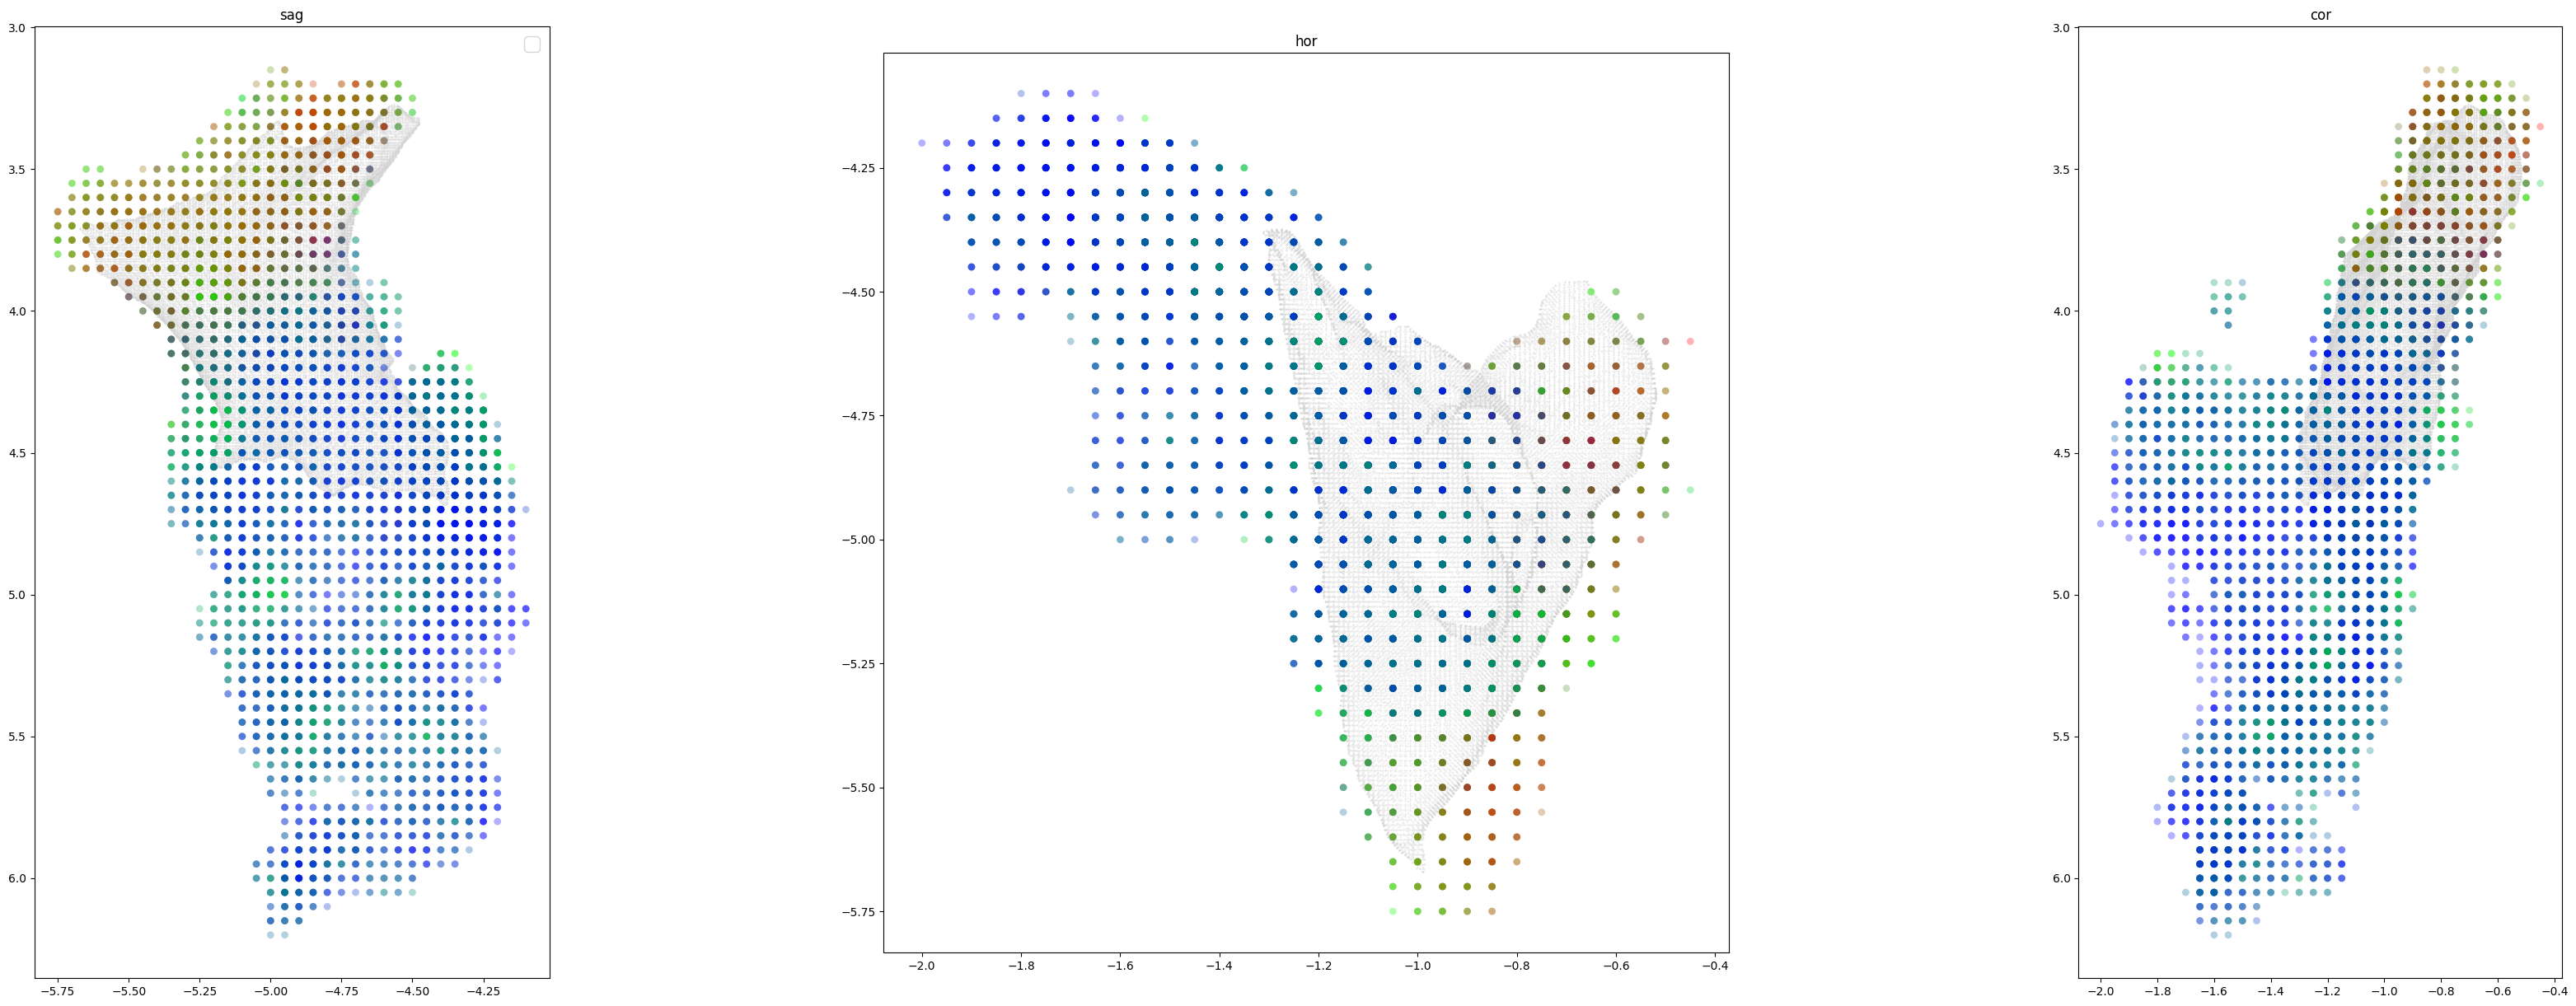

In [25]:
fig = plt.figure(figsize=(45, 15))
gs = fig.add_gridspec(1, 3)


green_white_magenta = LinearSegmentedColormap.from_list(
    "green_white_magenta",
    ["#00FF00", "#FFFFFF", "#FF00FF"]
)

ephys_primary_axis = np.array([ 0.39245173,  0.88519609, -0.24981898])
for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=1, s = 0.05)
    ax.scatter(grid_points[presence_mask_retro, planes_mesh[plane][0]], grid_points[presence_mask_retro, planes_mesh[plane][1]], c = retro_mean_rgb[presence_mask_retro], alpha=0.3, s = 40, edgecolors='none')
    ax.set_title(plane)
    # if planes[plane][1] == dv:
    #     ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_space_retro[planes_mesh[plane][0]], -primary_axis_space_retro[planes_mesh[plane][1]],scale=3, color='red', label='retro')
    #     ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], ephys_primary_axis[planes_mesh[plane][0]], -ephys_primary_axis[planes_mesh[plane][1]],scale=3, color='k', label='waveforms')
    # else:
    #     ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], primary_axis_space_retro[planes_mesh[plane][0]], primary_axis_space_retro[planes_mesh[plane][1]],scale=3, color='red', label='retro')
    #     ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], ephys_primary_axis[planes_mesh[plane][0]], ephys_primary_axis[planes_mesh[plane][1]],scale=3, color='k', label='waveforms')
        

    if plane == 'sag':
        ax.legend(fontsize=17, loc='upper right')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    ax.set_aspect(aspect='equal')


In [18]:
# Assume X and Y are your input matrices
Xc = StandardScaler(with_std=False).fit_transform(retro_mean[presence_mask_merfish & presence_mask_retro])  # center only
Yc = StandardScaler(with_std=False).fit_transform(merfish_mean[presence_mask_merfish & presence_mask_retro])

cca = CCA(n_components=1)

cca.fit(Xc, Yc)
retro_axis = cca.x_weights_

In [19]:
retro_fitted, merfish_fitted = cca.fit_transform(Xc, Yc)
canonical_corrs = [np.corrcoef(retro_fitted[:, i], merfish_fitted[:, i])[0, 1] for i in range(retro_fitted.shape[1])]

/tmp/ipykernel_17531/1378452935.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  params_lin, _ = curve_fit(linear, merfish_fitted[:, 0], retro_fitted[:, 0], p0=[1, 0], xtol=1e-6, ftol=1e-6, maxfev=10000)


Text(0, 0.5, "Projection's projection")

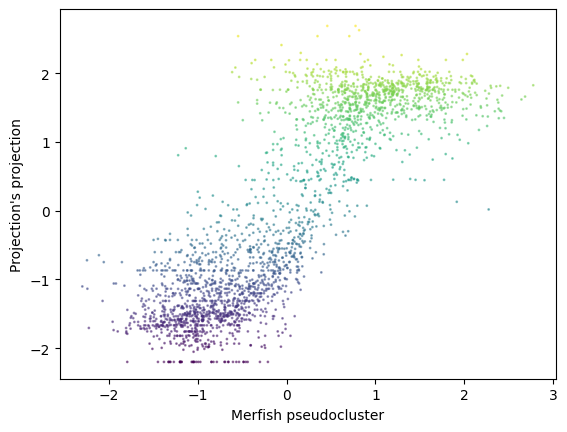

In [31]:
plt.scatter(merfish_fitted[:, 0], retro_fitted[:, 0], alpha=0.5, s=1, c=retro_fitted)
# fit a sigmoid to the data, x is merfish, y = retro
from scipy.optimize import curve_fit
def sigmoid(x, a, b, c, d):
    return c / (1 + np.exp(-a * (x - b))) + d
def linear(x, a, b):
    return a*x + b
# Fit the sigmoid function to the data
params, _ = curve_fit(sigmoid, merfish_fitted[:, 0], retro_fitted[:, 0], p0=[1, 0, 4, -2], xtol=1e-6, ftol=1e-6, maxfev=10000)
params_lin, _ = curve_fit(linear, merfish_fitted[:, 0], retro_fitted[:, 0], p0=[1, 0], xtol=1e-6, ftol=1e-6, maxfev=10000)

# Calculate the fitted y values using the sigmoid function
retro_fit = sigmoid(merfish_fitted, *params)
retro_fit_lin = linear(merfish_fitted, *params_lin)

r2_sigmoid = r2_score(retro_fitted[:, 0], retro_fit)
r2_linear = r2_score(retro_fitted[:, 0], retro_fit_lin)
# plt.scatter(merfish_fitted, retro_fit, color='red', label='Sigmoid Fit', s = 5)
# plt.scatter(merfish_fitted, retro_fit_lin, color='blue', label='Linear Fit', s = 5)
# plt.title(f'{canonical_corrs[0]:.2f} coeff, R2 sigmoid: {r2_sigmoid:.2f}, R2 linear: {r2_linear:.2f}')
plt.xlabel('Merfish pseudocluster')
plt.ylabel("Projection's projection")

Text(0.5, 1.0, 'Residuals of Linear Fit')

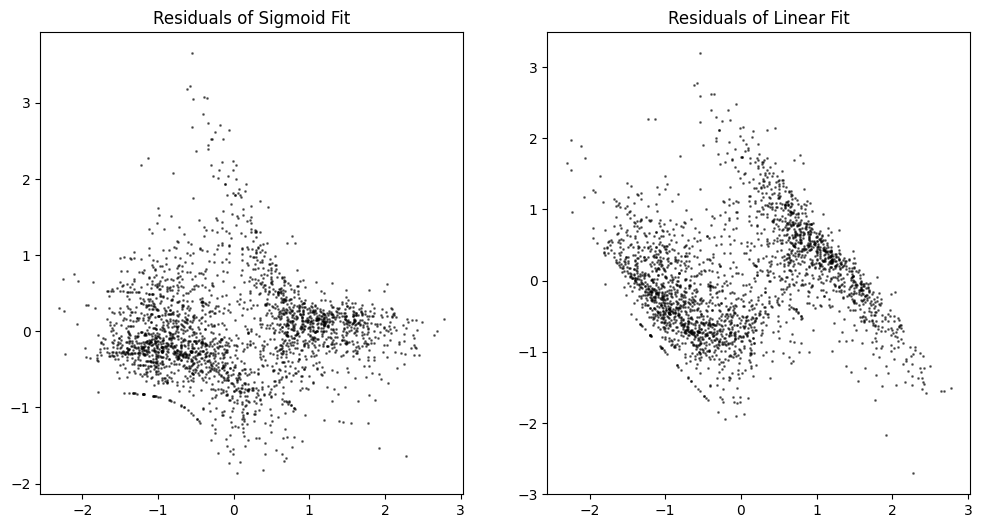

In [26]:
# residual plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(merfish_fitted, retro_fitted - retro_fit, alpha=0.5, s=1, color='k')
plt.title('Residuals of Sigmoid Fit')
plt.subplot(1, 2, 2)
plt.scatter(merfish_fitted, retro_fitted - retro_fit_lin, alpha=0.5, s=1, color='k')
plt.title('Residuals of Linear Fit')

Text(0.5, 1.0, 'Merfish CCA projection')

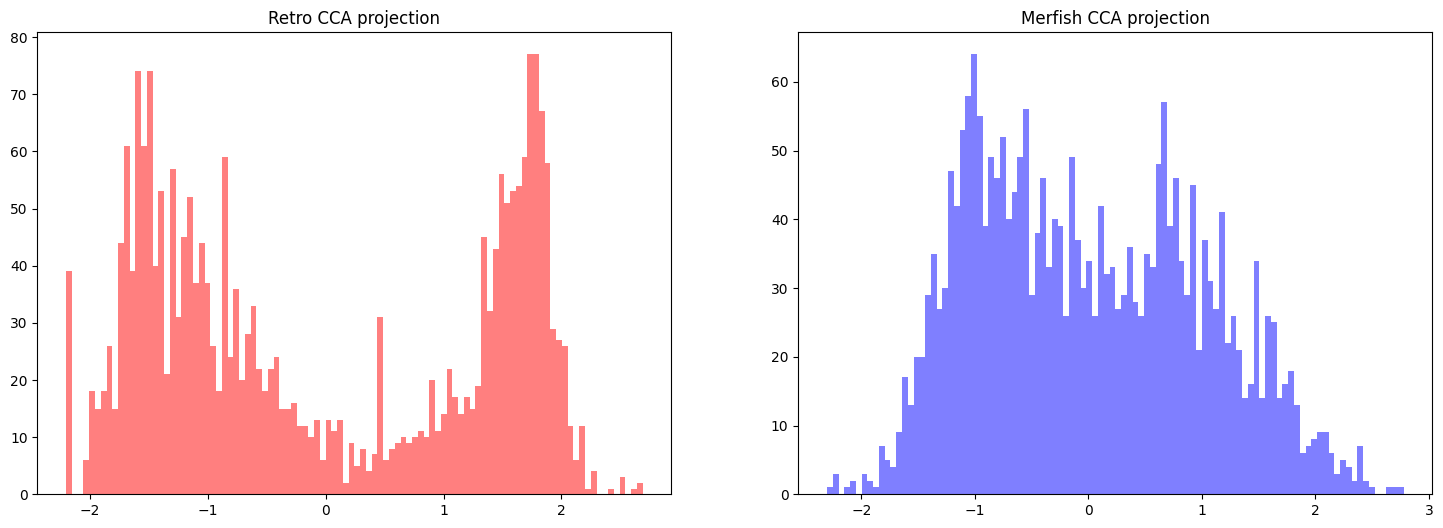

In [27]:
fig = plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(x=retro_fitted[:, 0], bins=100, color='r', alpha=0.5, label='retro')
plt.title('Retro CCA projection')
plt.subplot(1, 2, 2)
plt.hist(x=merfish_fitted[:, 0], bins=100, color='b', alpha=0.5, label='merfish')
plt.title('Merfish CCA projection')

In [28]:
# cca on location and retro_fitted
cca = CCA(n_components=1)
location_standard = StandardScaler(with_std=False).fit_transform(grid_points[presence_mask_retro & presence_mask_merfish])
cca.fit(location_standard, retro_fitted)
common_primary_axis = cca.x_weights_
common_primary_axis

array([[ 0.1868693 ],
       [ 0.89248762],
       [-0.4105432 ]])

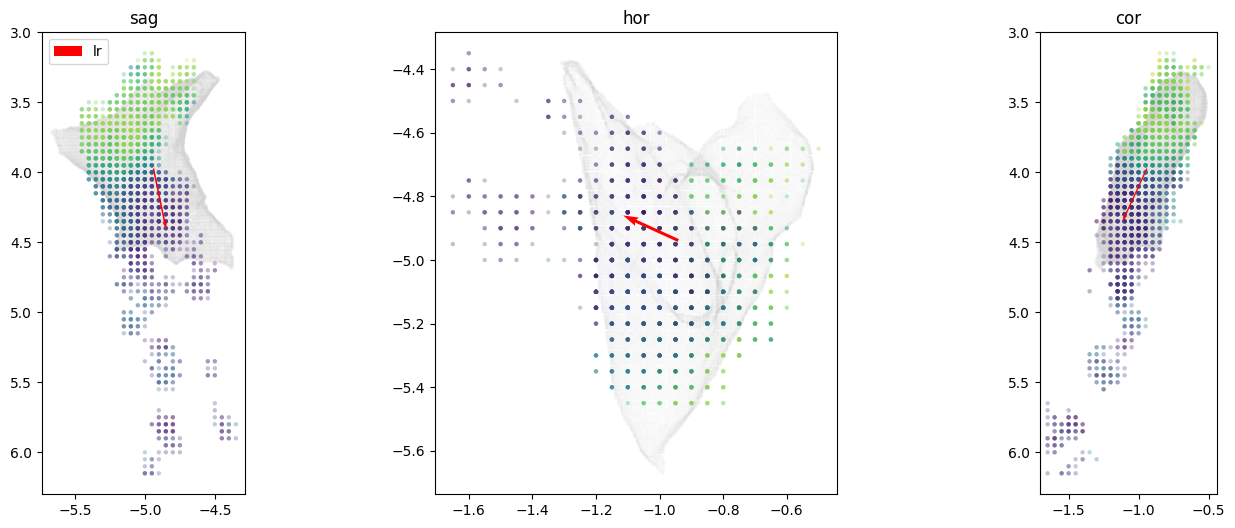

In [35]:
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)
from matplotlib.cm import plasma
from matplotlib.colors import to_hex
ephys_primary_axis = np.array([ 0.39245173,  0.88519609, -0.24981898])
green_white_magenta = LinearSegmentedColormap.from_list(
    "green_white_magenta",
    ["#00FF00", "#FFFFFF", "#FF00FF"]
)
for plane, ax_ind in zip(planes.keys(), range(3)):
    ax = fig.add_subplot(gs[ax_ind])
    # Plot the mesh
    # Plot the units with projection targets
    ax.scatter(mesh_vertices_mm[:, planes_mesh[plane][0]], mesh_vertices_mm[:, planes_mesh[plane][1]], color='lightgray', alpha=0.7, s = 0.002)
    ax.scatter(grid_points[presence_mask_retro & presence_mask_merfish, planes_mesh[plane][0]], grid_points[presence_mask_retro & presence_mask_merfish, planes_mesh[plane][1]], c = retro_fitted, alpha=0.3, s = 10, edgecolors='none')
    ax.set_title(plane)
    if planes[plane][1] == dv:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], common_primary_axis[planes_mesh[plane][0]], -common_primary_axis[planes_mesh[plane][1]],scale=3, color='red', label='lr')
    else:
        ax.quiver(ccf_center[planes_mesh[plane][0]], ccf_center[planes_mesh[plane][1]], common_primary_axis[planes_mesh[plane][0]], common_primary_axis[planes_mesh[plane][1]],scale=3, color='red', label='lr')

    if plane == 'sag':
        ax.legend()
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    ax.set_aspect(aspect='equal')
